In [1]:
import os
data_file_path = "data/"

dir_list = os.listdir(data_file_path)

In [2]:
dir_list_by_parameter = list(map(lambda x: x.split(":"), dir_list))

# dir_list_by_parameter[0]
# ['g_16000', 'p_10', 'wc_10', 'gs_42', 'ss_10', 'ipmutp_0.01', 'icmutp_0.005', 'icmaxsw_5', 'ccmutp_0.01.csv']
VARIABLE_A_INDEX = 6
VARIABLE_B_INDEX = 7

# extract unique numbers (ipmutp) and seeds
unique_ip_mut = set()
unique_seeds = set()
for i in range(len(dir_list_by_parameter)):
  unique_ip_mut.add(dir_list_by_parameter[i][VARIABLE_A_INDEX].split("_")[1])
  unique_seeds.add(dir_list_by_parameter[i][4].split("_")[1])

print(f"{len(unique_ip_mut)}, {len(unique_seeds)}")

15, 40


In [3]:
import pandas as pd

max_iters = 1500

fdf = pd.DataFrame()
for file in dir_list:
  ip_mut = float(file.split(":")[VARIABLE_A_INDEX].split("_")[1])
  seed = int(file.split(":")[4].split("_")[1])
  
  if seed not in [1]:
    continue
  
  df = pd.read_csv(f"{data_file_path}/{file}")
  df.rename(columns={'Unnamed: 0': 'generation'}, inplace=True)
  df['seed'] = [seed for _ in range(len(df))]
  df['ip_mut'] = [ip_mut for _ in range(len(df))]
  fdf = pd.concat((fdf, df[:max_iters]))

fdf.describe()

,generation,per_it_avg_total_length,per_it_avg_max_path_length,per_it_avg_fitness,per_it_best_fitness,seed,ip_mut
count,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.0,90000.000000
mean,749.500000,47446.563664,6233.483559,47446.563664,42499.862571,1.0,0.097067
std,433.015011,6245.190352,2119.662899,6245.190352,3412.154937,0.0,0.093369
min,0.000000,35710.302669,2725.913158,35710.302669,35710.302669,1.0,0.001000
25%,374.750000,42662.869870,4397.208898,42662.869870,40336.921552,1.0,0.008000
50%,749.500000,46004.083229,5903.610399,46004.083229,41866.856648,1.0,0.080000
75%,1124.250000,51121.307136,7859.353879,51121.307136,44116.923688,1.0,0.160000
max,1499.000000,77095.819814,14668.937676,77095.819814,57327.245614,1.0,0.300000


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# ax = sns.lineplot(data=fdf, x="generation", y="per_it_best_fitness", hue="ip_mut", legend=False)
# ax.set(xscale="log")
# plt.show()

# fig = ax.get_figure()
# fig.savefig("konvergencna_krivka.png") 


In [5]:
import numpy as np

max_iters = 250

fdf2 = pd.DataFrame()
result_mean = np.zeros((4, 15))
result_cnt = np.zeros((4, 15))

result_max = np.zeros((4, 15))
result_min = np.ones((4, 15)) * 10000000000

probs = np.array([0.001, 0.002, 0.005, 0.008, 0.01, 0.03, 0.05, 0.08, 0.1, 0.12, 0.14, 0.16, 0.20, 0.25, 0.3])
ic_swap_qs = np.array([2, 3, 4, 5])

for file in dir_list:
  ip_mut = round(float(file.split(":")[VARIABLE_A_INDEX].split("_")[1]), 3)
  ic_swap = int(file.split(":")[VARIABLE_B_INDEX].split("_")[1])
  seed = int(file.split(":")[4].split("_")[1])
  
  if seed in [43]: # remove garbage
    continue
  
  df = pd.read_csv(f"{data_file_path}/{file}")
  df.rename(columns={'Unnamed: 0': 'generation'}, inplace=True)
  df['seed'] = [seed for _ in range(len(df))]
  df['ic_mut'] = [ip_mut for _ in range(len(df))]
  df['ic_swap'] = [ic_swap for _ in range(len(df))]
  cdf = df[df['generation'] == max_iters]
  
  # create heat map
  p_index = np.argwhere(probs == ip_mut).astype(int)[0][0]
  q_index = np.argwhere(ic_swap_qs == ic_swap).astype(int)[0][0]
  
  result_cnt[q_index][p_index] += 1
  result_mean[q_index][p_index] += np.mean(cdf['per_it_best_fitness'])
  
  result_max[q_index][p_index] = np.max((result_max[q_index][p_index], np.max(cdf['per_it_best_fitness'])))
  result_min[q_index][p_index] = np.min((result_min[q_index][p_index], np.min(cdf['per_it_best_fitness']))) 
  
  fdf2 = pd.concat((fdf2, cdf))

result_mean_final = result_mean / result_cnt
fdf2.describe()

,generation,per_it_avg_total_length,per_it_avg_max_path_length,per_it_avg_fitness,per_it_best_fitness,seed,ic_mut,ic_swap
count,2400.0,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,250.0,49181.927843,6479.485565,49181.927843,44393.231876,20.500000,0.097067,3.500000
std,0.0,5759.374458,2144.410653,5759.374458,2296.600592,11.545802,0.093388,1.118267
min,250.0,38348.460462,2548.366609,38348.460462,38184.063212,1.000000,0.001000,2.000000
25%,250.0,44981.183000,4666.707672,44981.183000,42727.919707,10.750000,0.008000,2.750000
50%,250.0,47358.684495,6271.446790,47358.684495,44342.369074,20.500000,0.080000,3.500000
75%,250.0,52511.940907,8089.839466,52511.940907,45984.239712,30.250000,0.160000,4.250000
max,250.0,75703.970636,14301.384950,75703.970636,53025.547408,40.000000,0.300000,5.000000


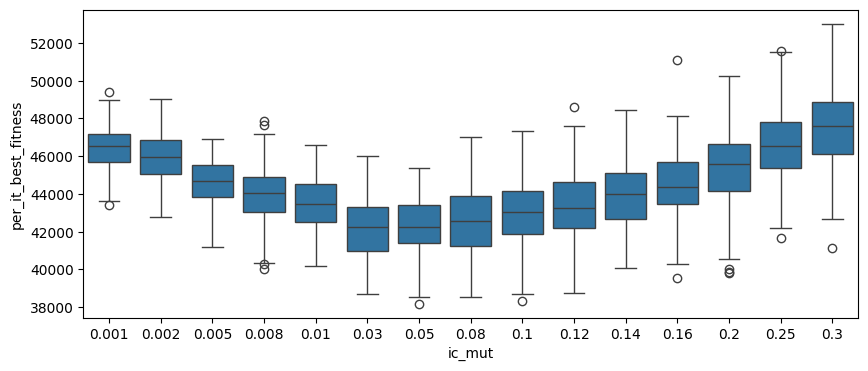

In [6]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = sns.boxplot(ax=ax, data=fdf2, x="ic_mut", y="per_it_best_fitness")
plt.show()

fig = ax.get_figure()
fig.savefig("boxplot_end.png") 

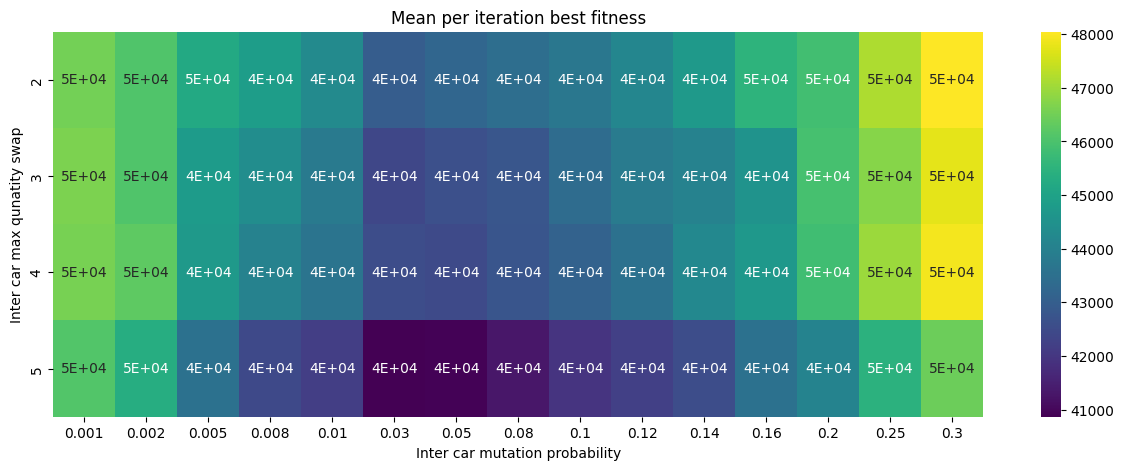

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.heatmap(result_mean_final, annot=True, fmt="2.0E", cmap='viridis')
ax.set(xlabel="Inter car mutation probability", ylabel="Inter car max qunatity swap")
ax.set_title("Mean per iteration best fitness")
ax.set_xticklabels(probs)
ax.set_yticklabels(ic_swap_qs)
plt.show()

fig = ax.get_figure()
fig.savefig("mean_per_iteration_best_fitness.png") 

In [8]:
import duckdb
from scipy import stats

resdf_2 = duckdb.sql("SELECT * FROM fdf2 WHERE ic_mut = 0.03 AND ic_swap = 2").df()
resdf_5 = duckdb.sql("SELECT * FROM fdf2 WHERE ic_mut = 0.03 AND ic_swap = 5").df()
pibf_2 = resdf_2['per_it_best_fitness'].tolist()
pibf_5 = resdf_5['per_it_best_fitness'].tolist()

stat, pvalue = stats.mannwhitneyu(pibf_2, pibf_5)
print(f"P-value: {pvalue}")

P-value: 3.6111613682133756e-08


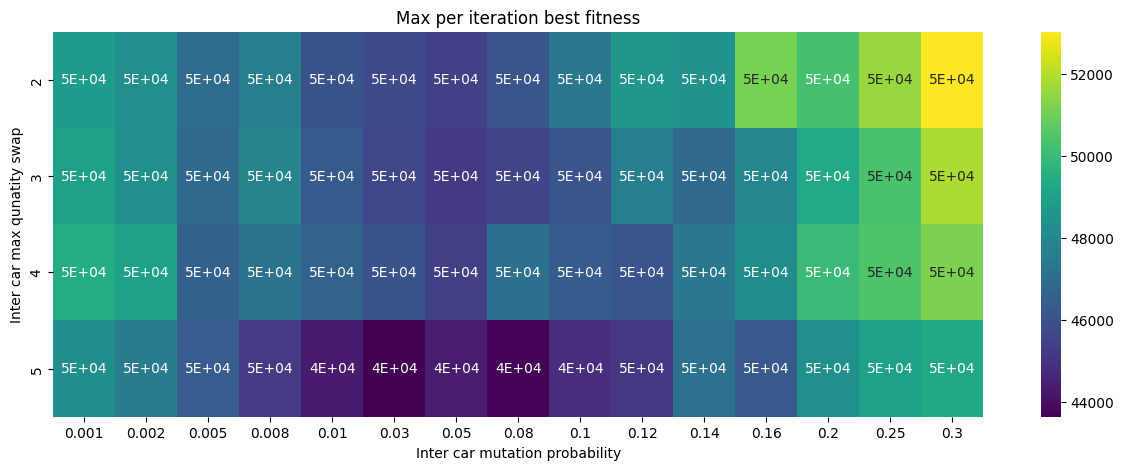

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.heatmap(result_max, annot=True, fmt="2.0E", cmap='viridis')
ax.set(xlabel="Inter car mutation probability", ylabel="Inter car max qunatity swap")
ax.set_title("Max per iteration best fitness")
ax.set_xticklabels(probs)
ax.set_yticklabels(ic_swap_qs)
plt.show()

fig = ax.get_figure()
fig.savefig("max_per_iteration_best_fitness.png") 

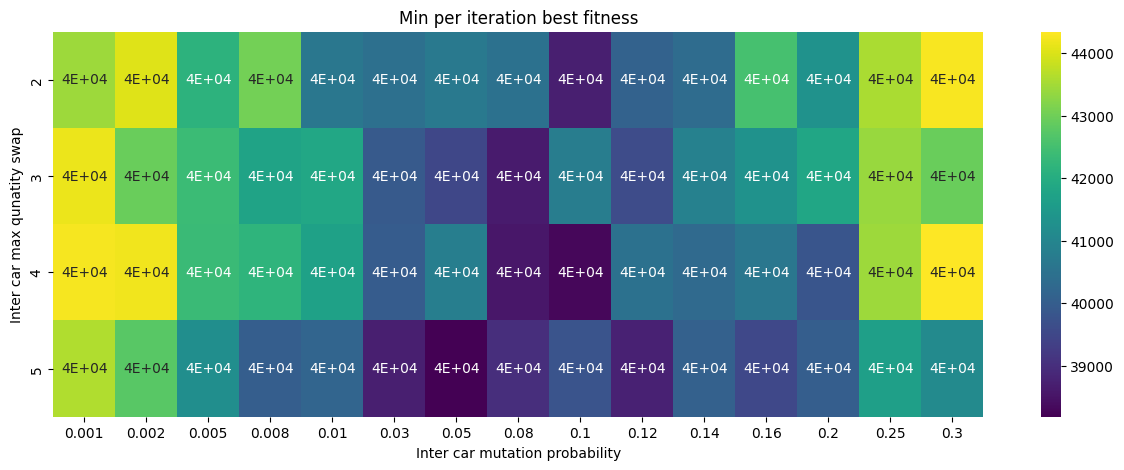

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.heatmap(result_min, annot=True, fmt="3.0E", cmap='viridis')
ax.set(xlabel="Inter car mutation probability", ylabel="Inter car max qunatity swap")
ax.set_title("Min per iteration best fitness")
ax.set_xticklabels(probs)
ax.set_yticklabels(ic_swap_qs)
plt.show()

fig = ax.get_figure()
fig.savefig("min_per_iteration_best_fitness.png") 

In [11]:
max_iters = 1499

fdf2 = pd.DataFrame()
result_mean = np.zeros((4, 15))
result_cnt = np.zeros((4, 15))

result_max = np.zeros((4, 15))
result_min = np.ones((4, 15)) * 10000000000

probs = np.array([0.001, 0.002, 0.005, 0.008, 0.01, 0.03, 0.05, 0.08, 0.1, 0.12, 0.14, 0.16, 0.20, 0.25, 0.3])
ic_swap_qs = np.array([2, 3, 4, 5])

for file in dir_list:
  ip_mut = round(float(file.split(":")[VARIABLE_A_INDEX].split("_")[1]), 3)
  ic_swap = int(file.split(":")[VARIABLE_B_INDEX].split("_")[1])
  seed = int(file.split(":")[4].split("_")[1])
  
  if seed in [43]: # remove garbage
    continue
  
  df = pd.read_csv(f"{data_file_path}/{file}")
  df.rename(columns={'Unnamed: 0': 'generation'}, inplace=True)
  df['seed'] = [seed for _ in range(len(df))]
  df['ic_mut'] = [ip_mut for _ in range(len(df))]
  df['ic_swap'] = [ic_swap for _ in range(len(df))]
  cdf = df[df['generation'] == max_iters]
  
  # create heat map
  p_index = np.argwhere(probs == ip_mut).astype(int)[0][0]
  q_index = np.argwhere(ic_swap_qs == ic_swap).astype(int)[0][0]
  
  result_cnt[q_index][p_index] += 1
  result_mean[q_index][p_index] += np.mean(cdf['per_it_best_fitness'])
  
  result_max[q_index][p_index] = np.max((result_max[q_index][p_index], np.max(cdf['per_it_best_fitness'])))
  result_min[q_index][p_index] = np.min((result_min[q_index][p_index], np.min(cdf['per_it_best_fitness']))) 
  
  fdf2 = pd.concat((fdf2, cdf))

result_mean_final = result_mean / result_cnt
fdf2.describe()

,generation,per_it_avg_total_length,per_it_avg_max_path_length,per_it_avg_fitness,per_it_best_fitness,seed,ic_mut,ic_swap
count,2400.0,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,1499.0,46570.236642,6286.149881,46570.236642,40827.216111,20.500000,0.097067,3.500000
std,0.0,6715.069645,2428.026866,6715.069645,2495.558695,11.545802,0.093388,1.118267
min,1499.0,34369.651152,2263.437066,34369.651152,32631.395359,1.000000,0.001000,2.000000
25%,1499.0,41535.485819,4107.249080,41535.485819,39091.073739,10.750000,0.008000,2.750000
50%,1499.0,44375.440859,6109.766106,44375.440859,40691.317561,20.500000,0.080000,3.500000
75%,1499.0,50504.257074,8241.770756,50504.257074,42442.918549,30.250000,0.160000,4.250000
max,1499.0,75051.874544,14306.561853,75051.874544,50192.439105,40.000000,0.300000,5.000000


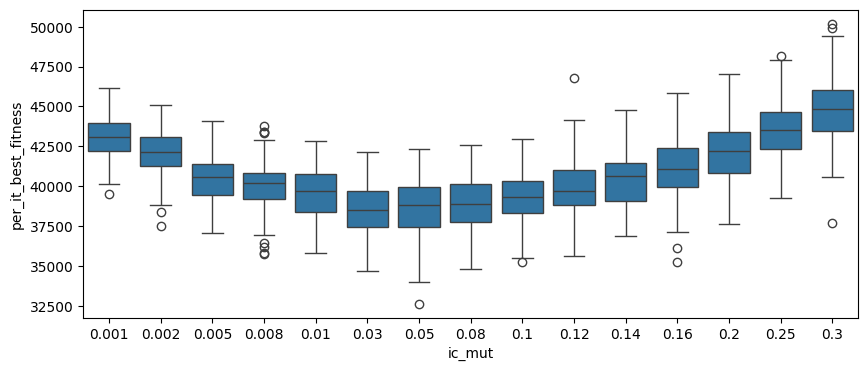

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = sns.boxplot(ax=ax, data=fdf2, x="ic_mut", y="per_it_best_fitness")
plt.show()

fig = ax.get_figure()
fig.savefig("boxplot_end.png") 

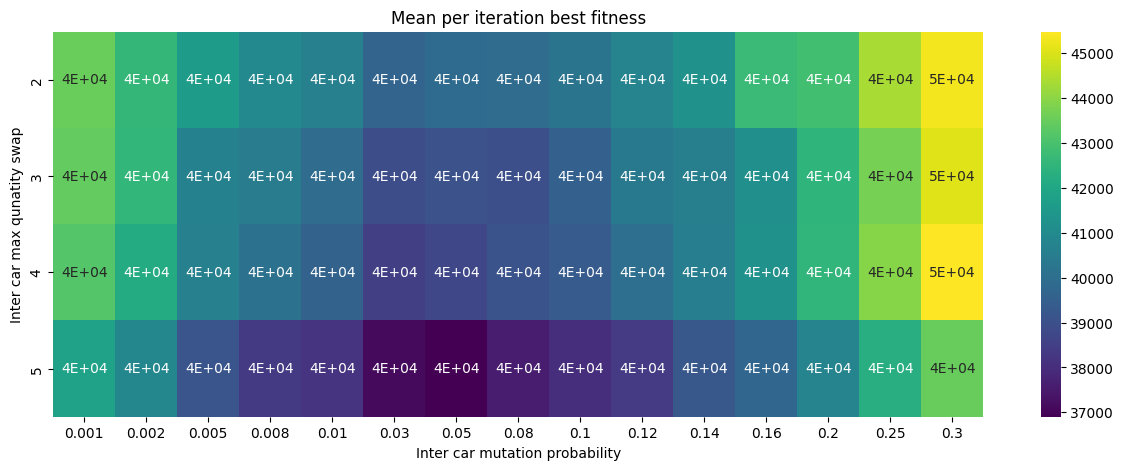

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.heatmap(result_mean_final, annot=True, fmt="2.0E", cmap='viridis')
ax.set(xlabel="Inter car mutation probability", ylabel="Inter car max qunatity swap")
ax.set_title("Mean per iteration best fitness")
ax.set_xticklabels(probs)
ax.set_yticklabels(ic_swap_qs)
plt.show()

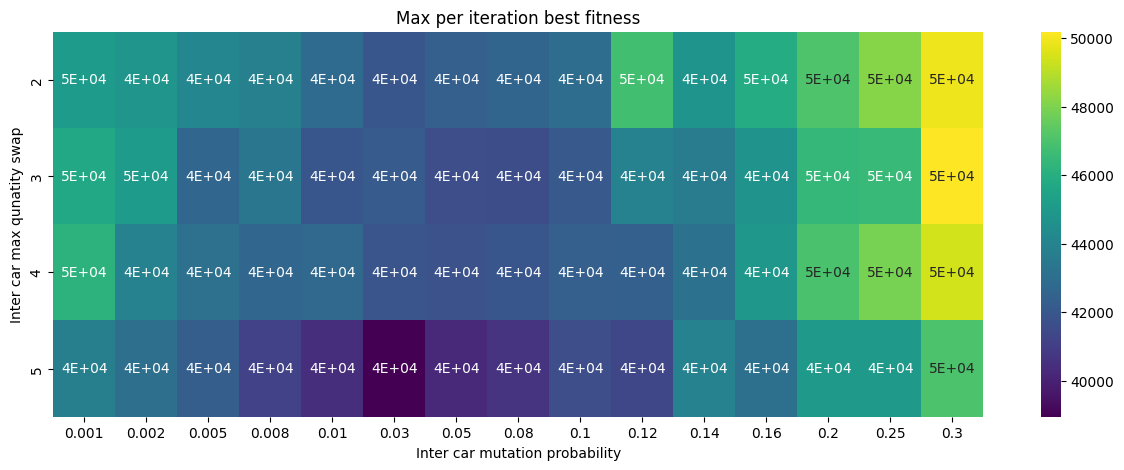

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.heatmap(result_max, annot=True, fmt="2.0E", cmap='viridis')
ax.set(xlabel="Inter car mutation probability", ylabel="Inter car max qunatity swap")
ax.set_title("Max per iteration best fitness")
ax.set_xticklabels(probs)
ax.set_yticklabels(ic_swap_qs)
plt.show()

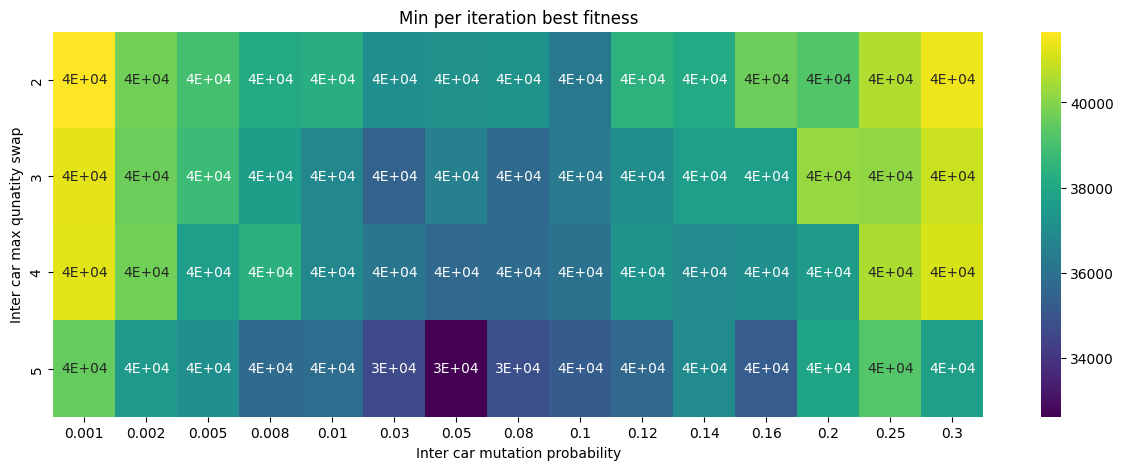

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.heatmap(result_min, annot=True, fmt="3.0E", cmap='viridis')
ax.set(xlabel="Inter car mutation probability", ylabel="Inter car max qunatity swap")
ax.set_title("Min per iteration best fitness")
ax.set_xticklabels(probs)
ax.set_yticklabels(ic_swap_qs)
plt.show()